In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost, time

from scipy import stats

from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid
from sklearn import metrics, ensemble

from sklearn.metrics import pairwise_distances, accuracy_score, f1_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.utils import resample

# Data Loading

In [2]:
test = pd.read_csv('D:\Data_Science\Instacart\order_products__test_cap.csv')
train = pd.read_csv('D:\Data_Science\Instacart\order_products__train_cap.csv')
prior = pd.read_csv('D:\Data_Science\Instacart\order_products__prior.csv', 
                    dtype={'order_id': np.int32,
                           'product_id': np.uint16,
                           'add_to_cart_order': np.int16,
                           'reordered': np.int8})
orders = pd.read_csv('D:\Data_Science\Instacart\orders.csv',
                    dtype={'order_id': np.int32,
                            'user_id': np.int64,
                            'eval_set': 'category',
                            'order_number': np.int16,
                            'order_dow': np.int8,
                            'order_hour_of_day': np.int8,
                            'days_since_prior_order': np.float32})
products = pd.read_csv('D:\Data_Science\Instacart\products.csv')
departments = pd.read_csv('D:\Data_Science\Instacart\departments.csv')
aisles = pd.read_csv('D:\Data_Science\Instacart\\aisles.csv')

# Data Exploration

In [3]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [4]:
print(len(test.order_id.unique()))
print(len(train.order_id.unique()))

32803
98406


In [5]:
print(len(prior.order_id.unique()))

3214874


In [6]:
orders.groupby('eval_set').count()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
eval_set,,,,,,
prior,3214874,3214874,3214874,3214874,3214874,3008665
test,75000,75000,75000,75000,75000,75000
train,131209,131209,131209,131209,131209,131209


In [7]:
orders = orders.loc[orders['eval_set'] != "test"]

In [8]:
orders.isin(test.order_id.tolist()).order_id.sum()

32803

In [9]:
orders.isin(train.order_id.tolist()).order_id.sum()

98406

In [10]:
orders.loc[(orders.index[orders.isin(test.order_id.tolist()).order_id]), 'eval_set'] = 'test'

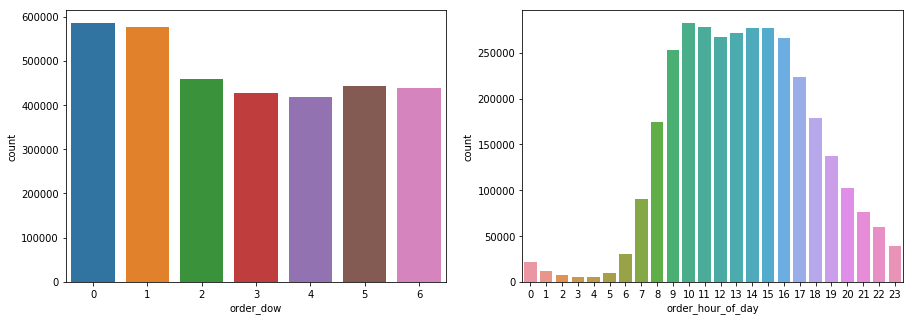

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(orders.order_dow);
plt.subplot(122)
sns.countplot(orders.order_hour_of_day);

In [12]:
prior = pd.merge(prior, orders, on='order_id', how='left')

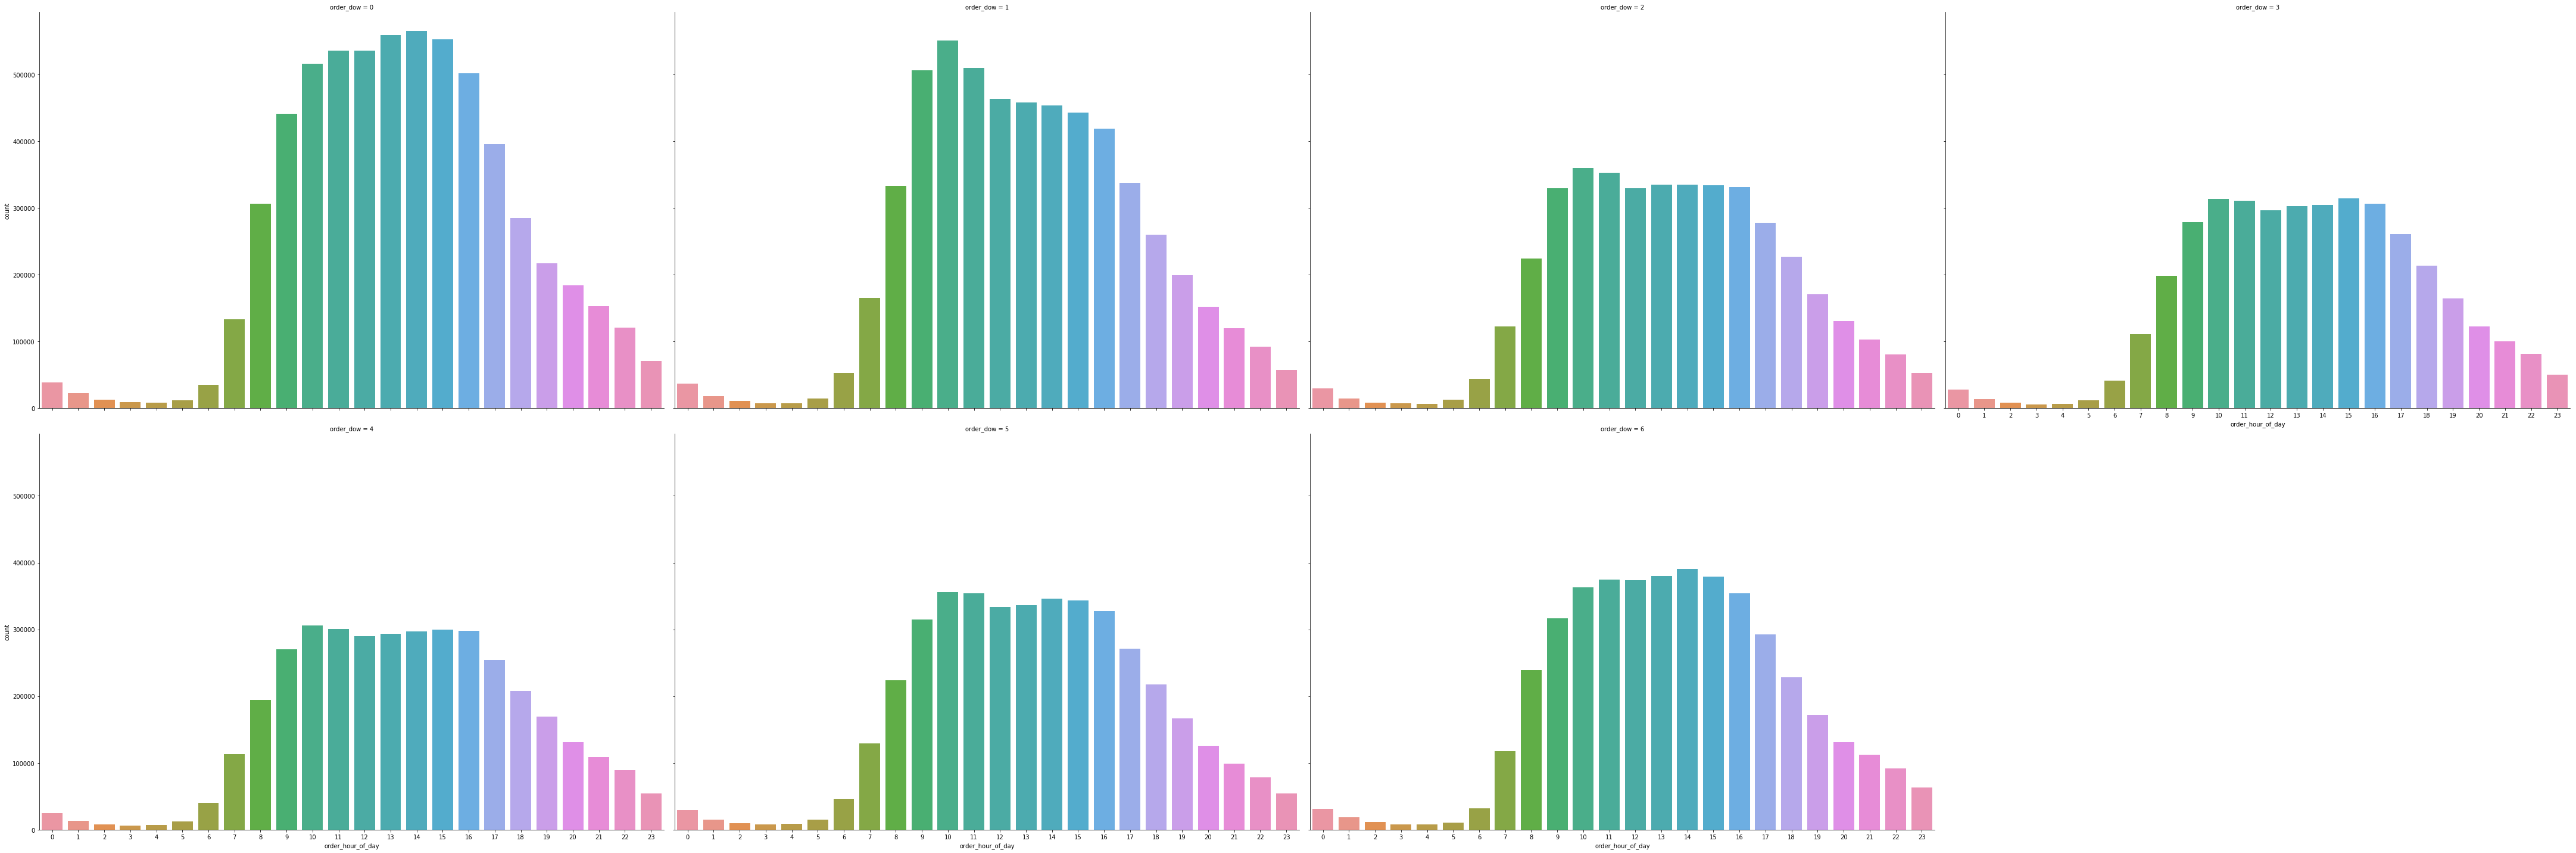

In [13]:
g = sns.catplot(x="order_hour_of_day" , col="order_dow", data=prior, kind="count", 
                height=10, aspect=1.5, col_wrap=4);

In [14]:
g.savefig("order_hour_day_count.png")

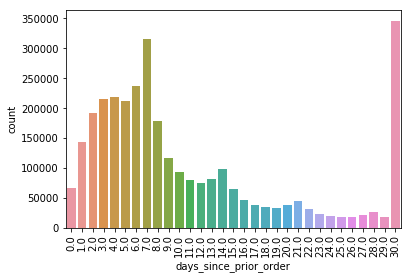

In [15]:
days_count = sns.countplot(orders.days_since_prior_order)
days_count.set_xticklabels(days_count.get_xticklabels(), rotation=90);

In [16]:
prior = pd.merge(prior, products, on='product_id', how='left')
prior = pd.merge(prior, departments, on='department_id', how='left')
prior = pd.merge(prior, aisles, on='aisle_id', how='left')
del departments
del aisles

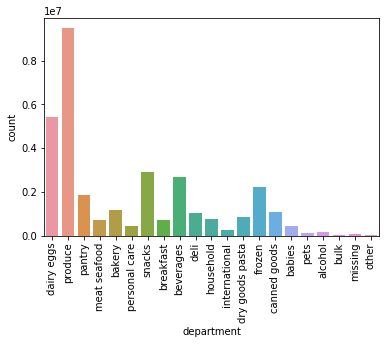

In [17]:
dep_count = sns.countplot(prior.department)
dep_count.set_xticklabels(dep_count.get_xticklabels(), rotation=90);

In [18]:
means = prior.groupby('department').mean()[['add_to_cart_order', 'reordered', 'order_dow', 'days_since_prior_order']]

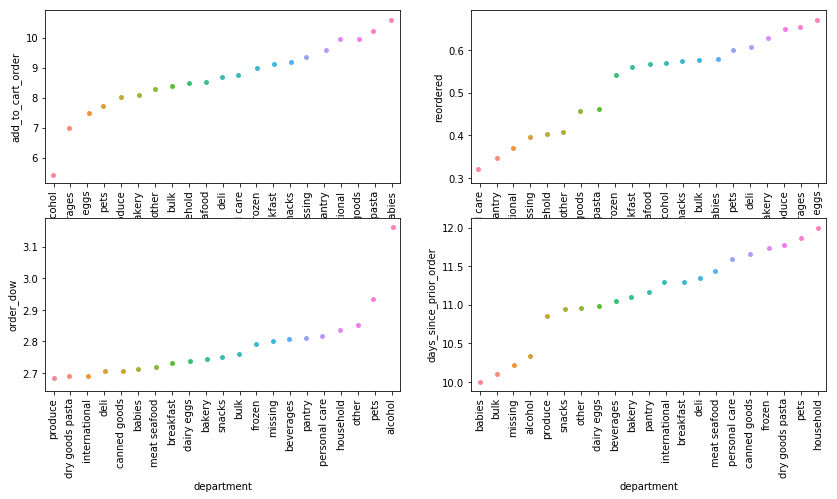

In [19]:
plt.figure(figsize=(14,7))
plt.subplot(221)
g = sns.stripplot(x=means.add_to_cart_order.sort_values().index, 
                  y=means.add_to_cart_order.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.subplot(222)
g = sns.stripplot(x=means.reordered.sort_values().index, 
                  y=means.reordered.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.subplot(223)
g = sns.stripplot(x=means.order_dow	.sort_values().index, 
                  y=means.order_dow	.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.subplot(224)
g = sns.stripplot(x=means.days_since_prior_order.sort_values().index, 
                  y=means.days_since_prior_order.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [20]:
del means

C:\Users\Val\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


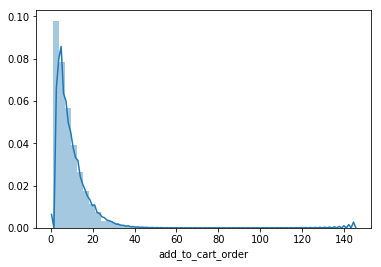

In [21]:
sns.distplot(prior.add_to_cart_order);

In [22]:
np.max(prior.add_to_cart_order)

145

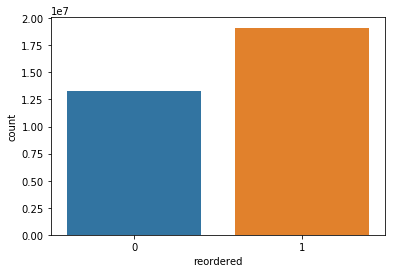

In [23]:
sns.countplot(prior.reordered);

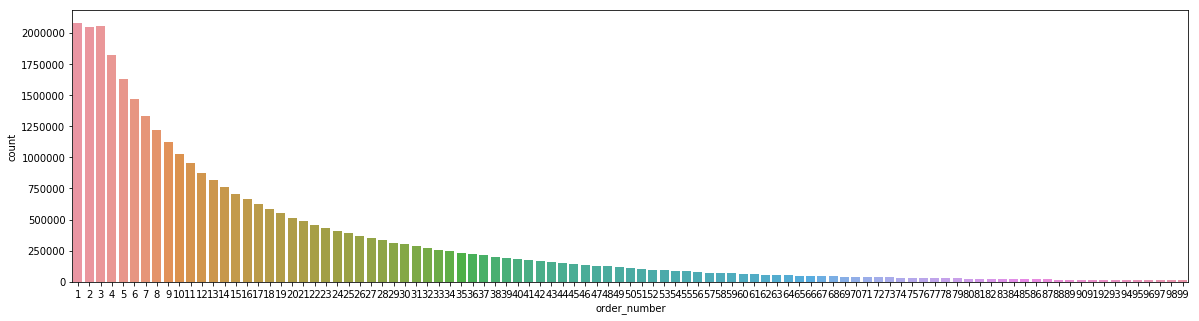

In [24]:
plt.figure(figsize=(20,5))
sns.countplot(prior.order_number);

# Feature generation

In [26]:
train = train.merge(right=orders, how='left', on='order_id')
test = test.merge(right=orders, how='left', on='order_id')

In [27]:
train.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,36,39612,1,0,79431,train,23,6,18,30.0
1,36,19660,2,1,79431,train,23,6,18,30.0


In [28]:
test.head(2)

,order_id,product_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,112108,test,4,4,10,9.0
1,1,11109,112108,test,4,4,10,9.0


## User features

In [29]:
user_features = pd.concat([
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_number'].max().rename('user_total_orders'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['days_since_prior_order'].sum().rename('total_days_since'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['days_since_prior_order'].mean().rename('avg_days_since'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_dow'].mean().rename('avg_dow'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_dow'].apply(lambda x: stats.mode(x)[0][0]).rename('most_common_dow'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_hour_of_day'].mean().rename('avg_hour'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_hour_of_day'].apply(lambda x: stats.mode(x)[0][0]).rename('most_common_hour'),
    prior.groupby("user_id")['product_id'].apply(set).rename('all_products')
], axis=1).reset_index()

In [30]:
user_features_2 = pd.concat([
    prior.groupby('user_id')['product_id'].count().rename('user_total_products'),
    prior.groupby('user_id')['product_id'].nunique().rename('user_distinct_products'),
], axis=1).reset_index()

In [31]:
user_features = pd.merge(user_features, user_features_2, on='user_id', how='left')
del user_features_2

In [32]:
user_features['avg_order_size'] = user_features.user_total_products/user_features.user_total_orders
user_features['avg_days_since'] = user_features.total_days_since/(user_features.user_total_orders - 1)
user_features['distinct_per_order'] = user_features.user_distinct_products/user_features.user_total_orders

In [33]:
user_features.head(1)

,user_id,user_total_orders,total_days_since,avg_days_since,avg_dow,most_common_dow,avg_hour,most_common_hour,all_products,user_total_products,user_distinct_products,avg_order_size,distinct_per_order
0,1,10,176.0,19.555555,2.500000,1,10.300000,7,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",59,18,5.900000,1.800000
1,2,14,198.0,15.230769,2.142857,1,10.571429,10,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",195,102,13.928571,7.285714


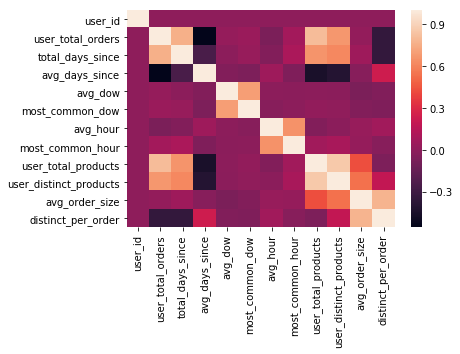

In [34]:
sns.heatmap(user_features.corr());

In [35]:
for k in range(2,11):
    minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=k,
    batch_size=20000,
    random_state=42
    )
    minibatchkmeans.fit(user_features.drop(['user_id', 'all_products'], axis=1))

    #y_pred = minibatchkmeans.predict(user_features.drop(['user_id', 'all_products'], axis=1))

    labels = minibatchkmeans.labels_
    print(k)
    print(metrics.silhouette_score(user_features.drop(['user_id', 'all_products'], axis=1), 
                                   labels, 
                                   metric='euclidean', 
                                   sample_size=10000,
                                   random_state=42))

2
0.6739354258524997
3
0.5546252113731074
4
0.4981817399421154
5
0.4148289611669523
6
0.38983036965379114
7
0.39226131132482434
8
0.3547241711233755
9
0.3648251517018756
10
0.35753495189064216


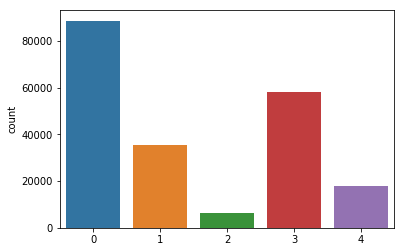

In [36]:
minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=5,
    batch_size=20000,
    random_state=41
    )

minibatchkmeans.fit(user_features.drop(['user_id', 'all_products'], axis=1))

y_pred = minibatchkmeans.predict(user_features.drop(['user_id', 'all_products'], axis=1))

sns.countplot(y_pred);

In [37]:
user_features['user_group'] = y_pred

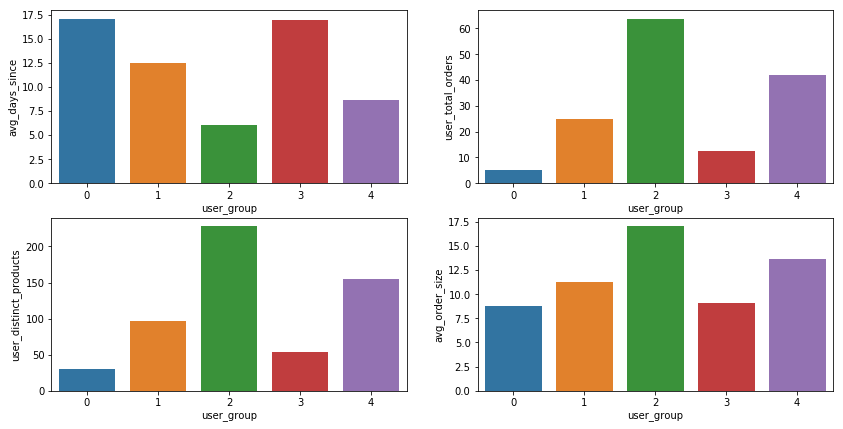

In [38]:
plt.figure(figsize=(14,7))
plt.subplot(221)
g = sns.barplot(x=user_features.groupby('user_group').mean().avg_days_since.index,
                y=user_features.groupby('user_group').mean().avg_days_since);
plt.subplot(222)
g = sns.barplot(x=user_features.groupby('user_group').mean().user_total_orders.index,
                y=user_features.groupby('user_group').mean().user_total_orders);
plt.subplot(223)
g = sns.barplot(x=user_features.groupby('user_group').mean().user_distinct_products.index,
                y=user_features.groupby('user_group').mean().user_distinct_products);
plt.subplot(224)
g = sns.barplot(x=user_features.groupby('user_group').mean().avg_order_size.index,
                y=user_features.groupby('user_group').mean().avg_order_size);

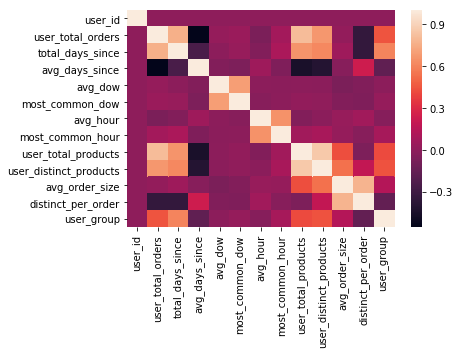

In [39]:
sns.heatmap(user_features.corr());

## Product features

In [40]:
product_features = pd.concat([
    prior.groupby("product_id")['order_id'].count().rename('product_total_orders'),
    prior.groupby("product_id")['add_to_cart_order'].mean().rename('avg_add_to_cart_order'),
    prior.groupby("product_id")['reordered'].sum().rename('total_product_reorders'),
    prior.groupby("product_id")['reordered'].mean().rename('avg_product_reorders'),
    prior.groupby("product_id")['order_dow'].mean().rename('prod_avg_dow'),
    prior.groupby("product_id")['days_since_prior_order'].mean().rename('prod_avg_days_since_prior'),
    prior.groupby("product_id")['order_hour_of_day'].mean().rename('prod_avg_hour')
], axis=1).reset_index()
del prior

In [41]:
product_features = pd.merge(product_features, products, on='product_id', how='right')

In [42]:
product_features.isna().sum()

product_id                    0
product_total_orders         11
avg_add_to_cart_order        11
total_product_reorders       11
avg_product_reorders         11
prod_avg_dow                 11
prod_avg_days_since_prior    42
prod_avg_hour                11
product_name                  0
aisle_id                      0
department_id                 0
dtype: int64

In [43]:
### Fill the missing product information with the average observed, can take a while ###
product_features = product_features.fillna(product_features.mean())

In [44]:
product_features.isna().sum()

product_id                   0
product_total_orders         0
avg_add_to_cart_order        0
total_product_reorders       0
avg_product_reorders         0
prod_avg_dow                 0
prod_avg_days_since_prior    0
prod_avg_hour                0
product_name                 0
aisle_id                     0
department_id                0
dtype: int64

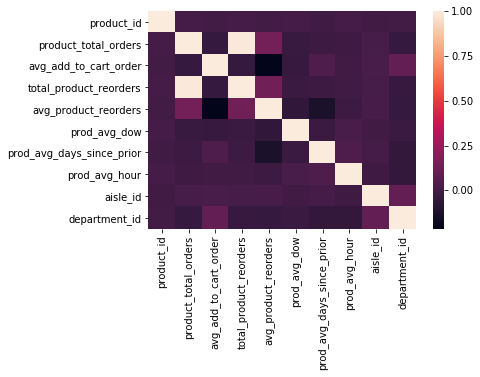

In [45]:
sns.heatmap(product_features.corr());

In [46]:
product_features_dummies = pd.get_dummies(product_features, columns=['department_id', 'aisle_id'])

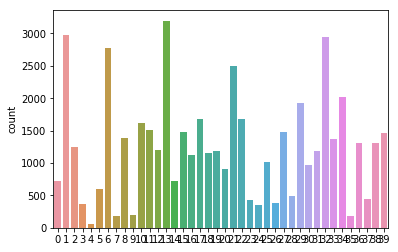

In [47]:
kmeans = KMeans(n_clusters=40,
                init='k-means++',
                precompute_distances='auto',
                random_state=41)

#kmeans.fit(product_features_dummies.drop(['product_id', 'product_name'], axis=1))
kmeans.fit(product_features_dummies.drop(['product_id', 'product_total_orders', 'avg_add_to_cart_order',
       'total_product_reorders', 'avg_product_reorders', 'prod_avg_dow', 'product_name'], axis=1))

y_pred = kmeans.predict(product_features_dummies.drop(['product_id', 'product_total_orders', 'avg_add_to_cart_order',
       'total_product_reorders', 'avg_product_reorders', 'prod_avg_dow', 'product_name'], axis=1))

sns.countplot(y_pred);

In [48]:
product_features['product_group'] = y_pred

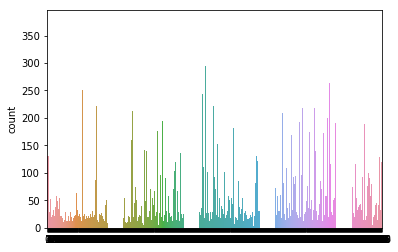

In [52]:
minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=1000,
    batch_size=1000,
    random_state=41
    )

minibatchkmeans.fit(product_features.drop(['product_id', 'product_name'], axis=1))

y_pred = minibatchkmeans.predict(product_features.drop(['product_id', 'product_name'], axis=1))

g = sns.countplot(y_pred)
g.figure.savefig("1000_clusters_kmeans_products.png")
plt.show()

In [54]:
labels = minibatchkmeans.labels_
print(metrics.silhouette_score(product_features.drop(['product_id', 'product_name'], axis=1), 
                                labels, 
                                metric='euclidean', 
                                sample_size=1000,
                                random_state=42))

0.07636638393009117


# Modeling

In [55]:
user_features.head(1)

,user_id,user_total_orders,total_days_since,avg_days_since,avg_dow,most_common_dow,avg_hour,most_common_hour,all_products,user_total_products,user_distinct_products,avg_order_size,distinct_per_order,user_group
0,1,10,176.0,19.555555,2.5,1,10.3,7,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",59,18,5.9,1.8,3


In [56]:
product_features.head(1)

,product_id,product_total_orders,avg_add_to_cart_order,total_product_reorders,avg_product_reorders,prod_avg_dow,prod_avg_days_since_prior,prod_avg_hour,product_name,aisle_id,department_id,product_group
0,1,1852.0,5.801836,1136.0,0.613391,2.776458,10.432725,13.238121,Chocolate Sandwich Cookies,61,19,29


## Predicting the size of an order

In [57]:
train_test = train.set_index(['order_id', 'product_id'],  drop=False)

In [58]:
y_size = []
for ord in train_test.order_id.unique():
    y_size.append(len(train_test.loc[ord].index))

In [59]:
size = pd.DataFrame({'size':y_size, 'order_id':train_test.order_id.unique()})
del y_size
del train_test

In [60]:
orders = pd.merge(orders, size, on='order_id', how='left')
del size

In [61]:
X_train_size = orders[orders.eval_set=='train'].drop(columns=['order_id', 'eval_set'])
X_train_size = pd.merge(X_train_size, user_features, on='user_id', how='left')

In [63]:
y_train_size = X_train_size['size']
X_train_size = X_train_size.drop(columns=['user_id', 'size', 'all_products'])

In [64]:
X_train_size, X_test_size, y_train_size, y_test_size = train_test_split(X_train_size,
                                                                        y_train_size,
                                                                        test_size=0.2,
                                                                        random_state=42 )

In [65]:
rfc = ensemble.RandomForestClassifier(n_estimators=10,
                                      criterion='entropy',
                                      max_depth=10)

In [66]:
rfc.fit(X_train_size, y_train_size)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
y_pred_size = rfc.predict(X_test_size)

In [68]:
accuracy_score(y_pred_size, y_test_size)

0.10329234833858347

In [69]:
(y_pred_size/y_test_size).mean()

1.177343316681094

## Giving a list of recommended products

In [70]:
train_3 = pd.merge(train, orders, on=['order_id','user_id', 'eval_set','order_number','order_dow','order_hour_of_day','days_since_prior_order'], how='left')

In [71]:
test_3 = pd.merge(test, orders, on=['order_id','user_id', 'eval_set','order_number','order_dow','order_hour_of_day','days_since_prior_order'], how='left')
del orders

In [75]:
train_products = train_3.groupby("order_id")['product_id'].apply(set).rename('products_in_order')

In [76]:
train_3 = pd.merge(train_3, pd.DataFrame(train_products), on='order_id', how='left')
del train_products

In [77]:
train_3 = pd.merge(train_3, user_features, on='user_id', how='left')

In [78]:
test_3 = pd.merge(test_3, user_features, on='user_id', how='left')

In [80]:
random.seed(42)
prod_rand = np.random.randint(1,len(products)+1, size=(len(train_3)))
train_3['prod_id_rand'] = prod_rand
del prod_rand

C:\Users\Val\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


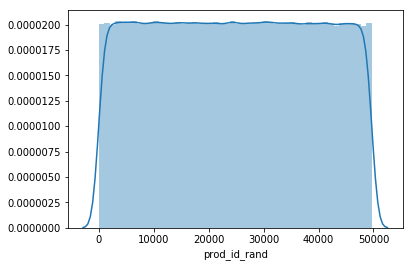

In [81]:
sns.distplot(train_3.prod_id_rand);

In [82]:
train_3_half_index = train_3.head(len(train_3)//2).index

In [83]:
train_with_fake = train_3.copy()

In [86]:
train_with_fake.loc[train_3_half_index, 'product_id'] = train_with_fake.iloc[train_3_half_index]['prod_id_rand']
train_with_fake['in_order'] = 1
train_with_fake.loc[train_3_half_index, 'in_order'] = 0

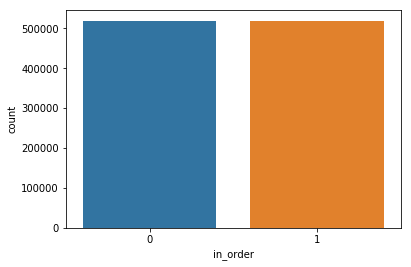

In [87]:
sns.countplot(train_with_fake.in_order);

In [88]:
train_with_fake = pd.merge(train_with_fake, product_features, on='product_id', how='left')

In [90]:
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(train_with_fake.drop(['order_id', 'product_id', 'add_to_cart_order',
                                                                               'reordered', 'user_id', 'eval_set',
                                                                               'size', 'products_in_order', 'all_products',
                                                                               'prod_id_rand', 'in_order', 'product_name',
                                                                               'aisle_id', 'department_id', 'size'], axis=1), 
                                                          train_with_fake.in_order,
                                                          test_size=0.2, random_state=42)

C:\Users\Val\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.637817
[10]	train-logloss:0.401933
[20]	train-logloss:0.349254
[30]	train-logloss:0.335865
[40]	train-logloss:0.331842
[49]	train-logloss:0.329799


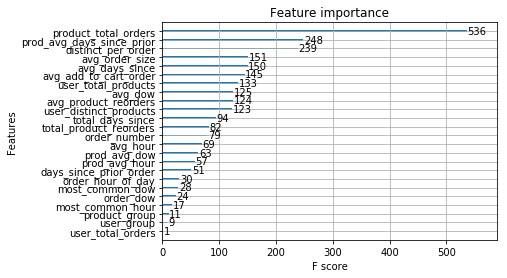

In [91]:
d_train = xgboost.DMatrix(X_train_3, y_train_3)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" : 10
    ,"gamma"            : 0.70
    ,"subsample"        : 0.76
    ,"colsample_bytree" : 0.95
    ,"alpha"            : 2e-05
    ,"lambda"           : 10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=50, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst);

In [96]:
d_val = xgboost.DMatrix(X_val_3)
y_val_3_predict = (bst.predict(d_val) > 0.5).astype(int)

In [97]:
accuracy_score(y_val_3_predict, y_val_3)

0.856737745723461

In [98]:
f1_score(y_val_3_predict, y_val_3)

0.8563303301563391

In [99]:
test_for_pred = test_3.drop(['product_id', 'user_id', 'eval_set',
                             'size', 'all_products'], axis=1)
products_for_pred = product_features.copy()
products_for_pred['order_id'] = 1
products_for_pred = pd.merge(products_for_pred, test_for_pred.drop_duplicates(subset=['order_id']), on='order_id', how='left')

In [100]:
X_test_3 = products_for_pred.drop(['product_id', 'product_name', 'aisle_id', 'department_id',
                                  'order_id'], axis=1)
X_test_3 = X_test_3[X_train_3.columns]

In [101]:
d_test = xgboost.DMatrix(X_test_3)

array([0.7089219 , 0.14726222, 0.3215036 , ..., 0.40250662, 0.40250662,
       0.40250662], dtype=float32)

In [102]:
(bst.predict(d_test) > 0.99).astype(int).sum()

12

In [103]:
y_test_3_predict = (bst.predict(d_test) > 0.99).astype(int)

In [104]:
products['selected'] = y_test_3_predict

In [115]:
for prod in list(test[test.order_id==1]['product_id']):
    products[products.product_id==prod][['product_name', 'aisle_id', 'department_id']]

In [119]:
products[(products.product_id==49302) | (products.product_id==11109) | (products.product_id==10246) |
        (products.product_id==49683) | (products.product_id==43633) |(products.product_id==13176) |
        (products.product_id==47209) |(products.product_id==22035)][['product_name', 'aisle_id', 'department_id']]

,product_name,aisle_id,department_id
10245,Organic Celery Hearts,83,4
11108,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
13175,Bag of Organic Bananas,24,4
22034,Organic Whole String Cheese,21,16
43632,Lightly Smoked Sardines in Olive Oil,95,15
47208,Organic Hass Avocado,24,4
49301,Bulgarian Yogurt,120,16
49682,Cucumber Kirby,83,4


In [107]:
products[products.selected==1]

,product_id,product_name,aisle_id,department_id,selected
13172,13173,Beef Ramen Noodle Soup,69,15,1
16793,16794,Compleats Microwavable Meal Chicken & Rice,4,9,1
21133,21134,Cream Top Apricot Mango Fruit on the Bottom Yo...,120,16,1
21899,21900,Alive! Children's Chewable Multivitamin Natura...,47,11,1
22931,22932,La Famiglia Del Grosso Tomato Basil Masterpiec...,9,9,1
24848,24849,Cheese & Fresh Herb Flatbread Pizza,79,1,1
24960,24961,Old Fashioned Smooth & Creamy Grits,130,14,1
27960,27961,Mentho Lyptus Cough Suppressant Oral Anestheti...,11,11,1
44998,44999,Uncured Pepper Salami,7,12,1
47198,47199,Rotelle,131,9,1


In [121]:
results = pd.DataFrame(index=products.index)
start_time = time.time()
start_time_total = time.time()
for i, order in enumerate(test_for_pred.order_id.unique()[:100]):
    products_for_pred = product_features.copy()
    products_for_pred['order_id'] = order
    products_for_pred = pd.merge(products_for_pred, test_for_pred.drop_duplicates(subset=['order_id']), on='order_id', how='left')
    X_test_3 = products_for_pred.drop(['product_id', 'product_name', 'aisle_id', 'department_id',
                                  'order_id'], axis=1)
    X_test_3 = X_test_3[X_train_3.columns]
    
    d_test = xgboost.DMatrix(X_test_3)
    bst.predict(d_test)
    
    y_test_3_predict = (bst.predict(d_test) > 0.99).astype(int)
    results = results.join(pd.DataFrame(y_test_3_predict, columns=[order]))
    
    if (i+1) % 10 == 0:
        iter_time = time.time() - start_time
        print('{} orders, done in {} seconds'.format(i+1,iter_time))
        start_time = time.time()
        
total_time = time.time() - start_time_total
print('Total time elapsed : {} seconds'.format(total_time))

10 orders, done in 2.5368714332580566 seconds
20 orders, done in 2.0831003189086914 seconds
30 orders, done in 2.0527167320251465 seconds
40 orders, done in 2.0837550163269043 seconds
50 orders, done in 2.0636165142059326 seconds
60 orders, done in 2.070664882659912 seconds
70 orders, done in 2.095961809158325 seconds
80 orders, done in 2.0519602298736572 seconds
90 orders, done in 2.0882112979888916 seconds
100 orders, done in 2.0825610160827637 seconds
Total time elapsed : 21.20941925048828 seconds


In [122]:
results.head(2)

,1,96,98,112,218,393,473,631,774,904,...,7318,7559,7627,7657,7741,7746,7865,8213,8231,8316
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### With dummies for department

In [123]:
train_with_fake_dummies = pd.get_dummies(train_with_fake, columns=['department_id'])

In [124]:
X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(
    train_with_fake_dummies.drop(['order_id', 'product_id', 'add_to_cart_order',
                                  'reordered', 'user_id', 'eval_set',
                                  'size', 'products_in_order', 'all_products',
                                  'prod_id_rand', 'in_order', 'product_name',
                                  'aisle_id'], axis=1), 
    train_with_fake_dummies.in_order,
    test_size=0.2, random_state=42)

[0]	train-logloss:0.637799
[10]	train-logloss:0.40182
[19]	train-logloss:0.351761


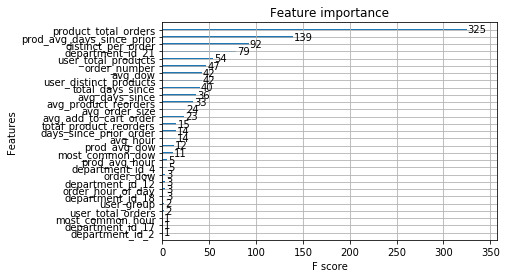

In [125]:
d_train_2 = xgboost.DMatrix(X_train_4, y_train_4)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" : 10
    ,"gamma"            : 0.70
    ,"subsample"        : 0.76
    ,"colsample_bytree" : 0.95
    ,"alpha"            : 2e-05
    ,"lambda"           : 10
}

watchlist= [(d_train_2, "train")]
bst_2 = xgboost.train(params=xgb_params, dtrain=d_train_2, num_boost_round=20, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst_2);

In [126]:
d_val_2 = xgboost.DMatrix(X_val_4)
bst_2.predict(d_val_2).max()

0.92816

In [130]:
(bst_2.predict(d_val_2) > 0.928).astype(int).sum()

17653

In [131]:
y_val_4_predict = (bst_2.predict(d_val_2) > 0.5).astype(int)

In [132]:
accuracy_score(y_val_4_predict, y_val_4)

0.8553704087085887

In [133]:
f1_score(y_val_4_predict, y_val_4)

0.8547796072668208

In [134]:
results_2 = pd.DataFrame(index=products.index)
start_time = time.time()
start_time_total = time.time()
for i, order in enumerate(test_for_pred.order_id.unique()[:10]):
    products_for_pred = product_features.copy()
    products_for_pred['order_id'] = order
    products_for_pred = pd.merge(products_for_pred, test_for_pred.drop_duplicates(subset=['order_id']), on='order_id', how='left')
    X_test_4 = products_for_pred.drop(['product_id', 'product_name', 
                                       'aisle_id', 'order_id'], axis=1)
    X_test_4 = pd.get_dummies(X_test_4, columns=['department_id'])
    X_test_4 = X_test_4[X_train_4.columns]
    
    d_test_2 = xgboost.DMatrix(X_test_4)
    #bst_2.predict(d_test_2)
    
    y_test_4_predict = (bst_2.predict(d_test_2) > 0.928).astype(int)
    results_2 = results_2.join(pd.DataFrame(y_test_4_predict, columns=[order]))
    
    if (i+1) % 10 == 0:
        iter_time = time.time() - start_time
        print('{} orders, done in {} seconds'.format(i+1, iter_time))
        start_time = time.time()
        
total_time = time.time() - start_time_total
print('Total time elapsed : {} seconds'.format(total_time))

10 orders, done in 2.6142842769622803 seconds
Total time elapsed : 2.6142842769622803 seconds


In [135]:
results_2.head(2)

,1,96,98,112,218,393,473,631,774,904
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
